In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import pickle
from IPython.display import clear_output

# ml libs
import keras
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping#, TensorBoard
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.optimizers import Adam 
from keras import models
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

Text(0.5, 1.0, 'Mask')

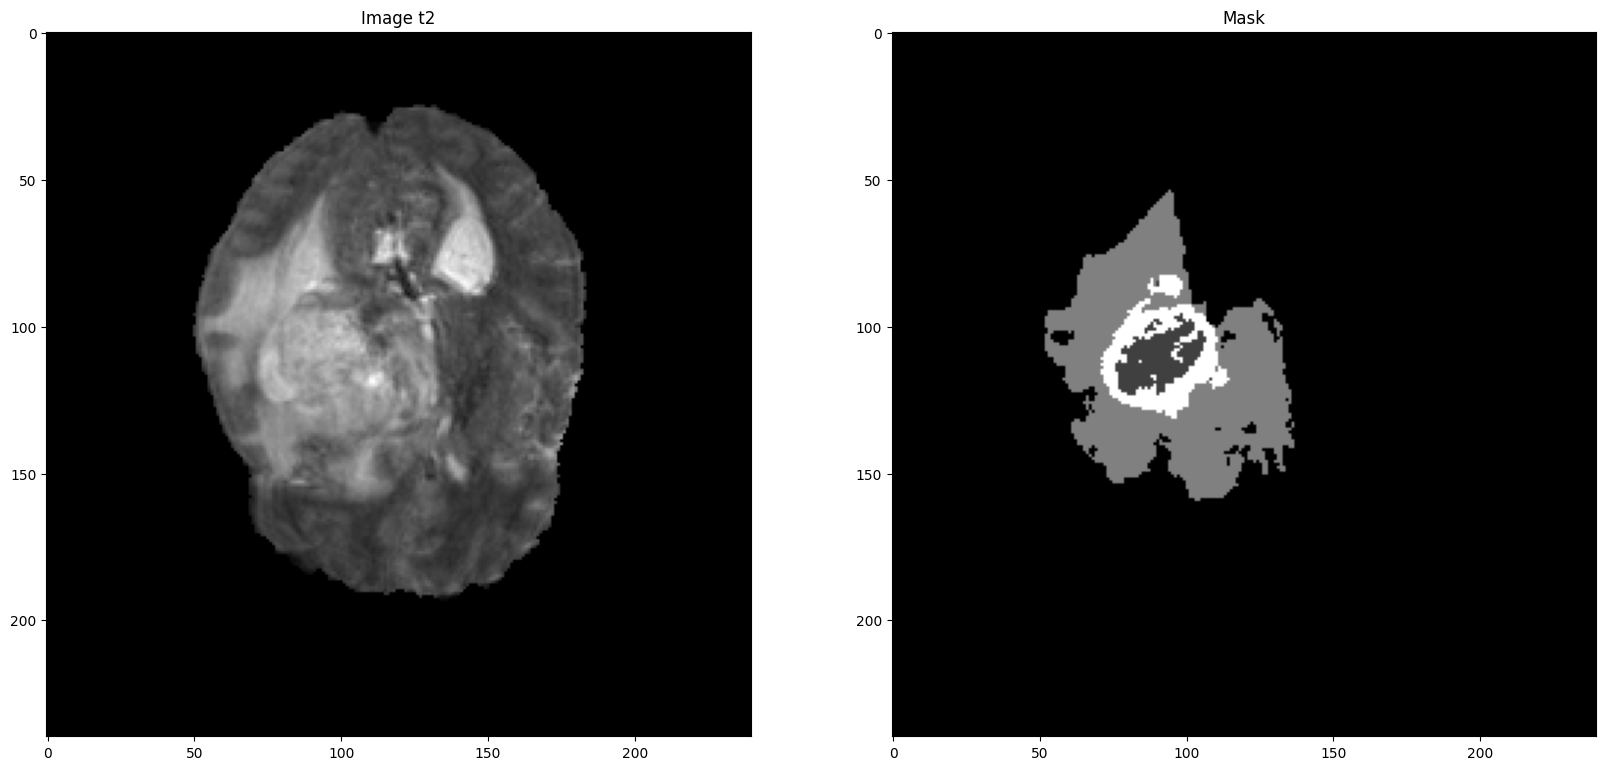

In [24]:
TRAIN_DATASET_PATH = 'data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

slice_w = 70

test_image_t2 = np.rot90(nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata(), 1)[:, :, slice_w]
test_mask=np.rot90(nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata(), 1)[:, :, slice_w]

fig, axs = plt.subplots(1,2, figsize = (20, 10))
axs[0].imshow(test_image_t2, cmap = 'gray')
axs[0].set_title('Image t2')
axs[1].imshow(test_mask, cmap = 'gray')
axs[1].set_title('Mask')


In [25]:
TRAIN_DATASET_PATH = 'data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

def find_max_necrotic(seg_image):
    # Initialize variables to keep track of max count and index
    max_count = 0
    max_idx = 0

    # Loop through all slices and count number of pixels with value 1
    for i in range(seg_image.shape[2]):
        count = np.count_nonzero(seg_image[:, :, i] == 1)
        if count > max_count:
            max_count = count
            max_idx = i
    return max_idx

def preprocess_dataset(dataset_path):

    folder_names = os.listdir(dataset_path)
    images = np.empty((len(folder_names), 240, 240, 1), dtype=np.uint8)
    masks = np.empty((len(folder_names), 240, 240, 1), dtype=np.uint8)

    for i, folder_name in enumerate(folder_names):
            folder_path = os.path.join(dataset_path, folder_name)
            if os.path.isdir(folder_path):
                seg_path = os.path.join(folder_path, f'{folder_name}_seg.nii')
                t2_path = os.path.join(folder_path, f'{folder_name}_t2.nii')
                if os.path.exists(t2_path) and os.path.exists(seg_path):

                    seg_image = np.rot90(nib.load(seg_path).get_fdata(), 1)
                    t2_image = np.rot90(nib.load(t2_path).get_fdata(), 1)
                    
                    slice_index = find_max_necrotic(seg_image)
                    
                    t2_image[:, :, slice_index] = (t2_image[:, :, slice_index] / np.max(t2_image[:, :, slice_index]) * 255).astype(np.uint8)
                    images[i,:,:,0] = t2_image[:, :, slice_index]
                    masks[i,:,:,0] = seg_image[:, :, slice_index]
    return images, masks

In [26]:
def create_enhance_masks(masks):
    new_masks = np.where((masks == 1) | (masks == 4), 256, 0)
    new_masks[masks == 2] = 0
    return new_masks

def create_necrotic_masks(masks):
    new_masks = np.where((masks == 2) | (masks == 4), 0, 0)
    new_masks[masks == 1] = 256
    return new_masks

def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i], cmap='gray')
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1], cmap='gray')
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2], cmap='gray')
        
        plt.show()

In [27]:
images, masks = preprocess_dataset(TRAIN_DATASET_PATH)

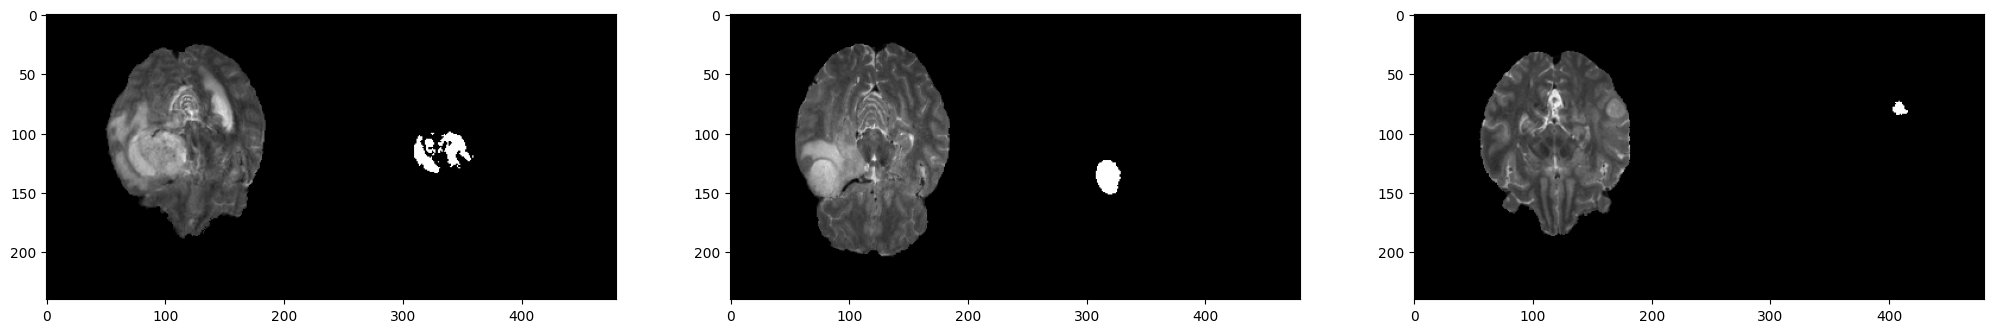

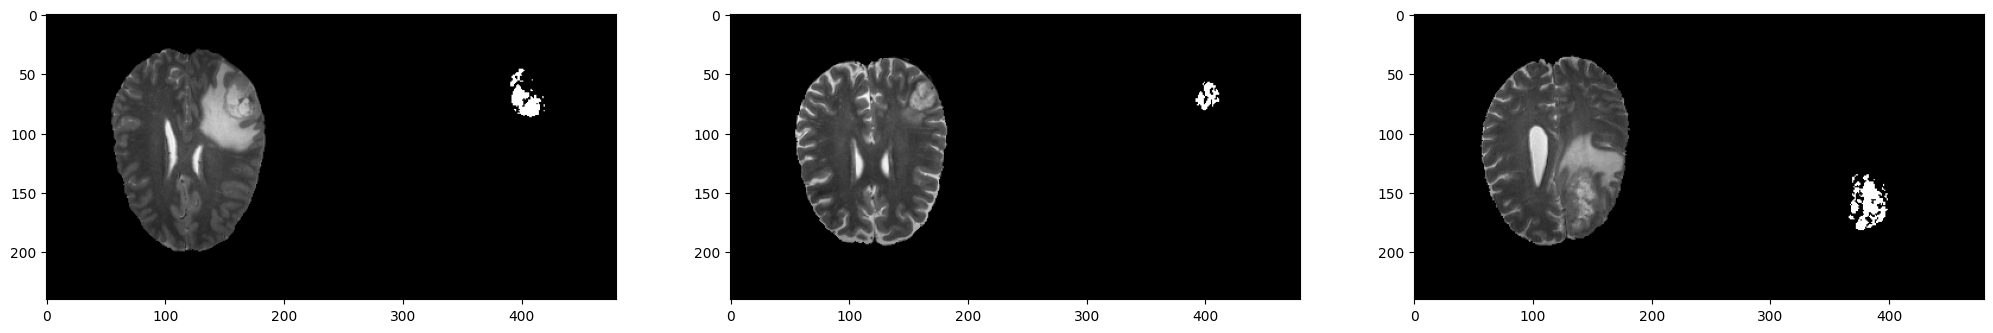

In [28]:
enhance_masks = create_enhance_masks(masks)
necrotic_masks = create_necrotic_masks(masks)
plotMask(images,necrotic_masks)

In [29]:
dim = 240
features = np.array(images).reshape(len(images),dim,dim,1)
necrotic_labels = np.array(necrotic_masks).reshape(len(necrotic_masks),dim,dim,1)
enhance_labels = np.array(enhance_masks).reshape(len(enhance_masks),dim,dim,1)

In [30]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [31]:
model = unet(input_size=(240,240,1))
model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()
clear_output()

In [32]:
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [33]:
train_image, test_image, train_mask, test_mask = train_test_split(images, masks, test_size = 0.1,random_state = 42)


def split(labels):

    train_vol, validation_vol, train_seg, validation_seg = train_test_split((features-127.0)/127.0, 
                                                                (labels>127).astype(np.float32), 
                                                                test_size = 0.1,random_state = 42)                                                     

    train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                                test_size = 0.1, 
                                                                random_state = 42)
    
    return train_vol, train_seg, validation_vol, validation_seg, test_vol, test_seg


In [34]:
def run_model(epochs, train_vol, train_seg, test_vol, test_seg):

  model = unet(input_size=(240,240,1))

  model.compile(optimizer=Adam(learning_rate=2e-4), 
                loss=[dice_coef_loss], 
            metrics = [dice_coef, 'binary_accuracy'])

  history = model.fit(x = train_vol,
                        y = train_seg,
                          batch_size = 16,
                    epochs = epochs,
                    validation_data =(test_vol,test_seg) ,
                    callbacks=callbacks_list)
  return model, history

In [35]:
def save_model(model, history, epochs, name):

    model.save("model_{}_{}.h5".format(name, epochs))

    with open('history_{}_{}.pkl'.format(name, epochs), 'wb') as f:
        pickle.dump(history.history, f)

def get_model(epochs, name):

    model = models.load_model("model_{}_{}.h5".format(name, epochs), 
                              custom_objects={ "dice_coef": dice_coef, "dice_coef_loss": dice_coef_loss}, compile=True)
    # Reload the history object
    with open('history_{}_{}.pkl'.format(name, epochs), 'rb') as f:
        history = pickle.load(f)

    return model, history

In [36]:
epochs = 20

train_vol, train_seg, validation_vol, validation_seg, test_vol, test_seg = split(enhance_labels)

model, history = run_model(epochs, train_vol, train_seg, test_vol, test_seg)

save_model(model, history, epochs, 'enhance')

clear_output()

Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: -0.0475 - dice_coef: 0.0474 - binary_accuracy: 0.9445WARNING:tensorflow:5 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x0000026726A14EE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.

Epoch 1: val_loss improved from inf to -0.07335, saving model to cxr_reg_weights.best.hdf5
19/19 [==============================] - 114s 6s/step - loss: -0.0475 - dice_coef: 0.0474 

In [ ]:
train_vol, train_seg, validation_vol, validation_seg, test_vol, test_seg = split(necrotic_labels)

model, history = run_model(epochs, train_vol, train_seg, test_vol, test_seg)

save_model(model, history, epochs, 'necrotic')

clear_output()

In [ ]:

model_enhance, history_enhance = get_model(epochs, 'enhance')
model_necrotic, history_necrotic = get_model(epochs, 'necrotic')

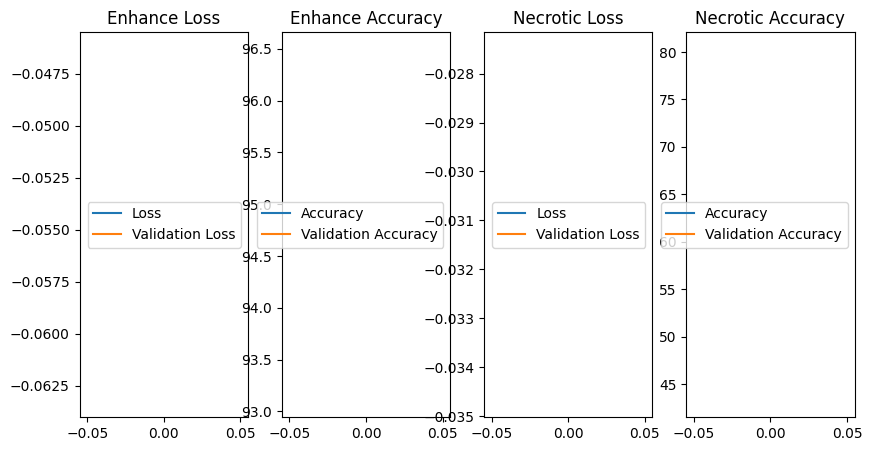

In [ ]:
fig, axs = plt.subplots(1, 4, figsize = (10, 5))

axs[0].plot(history_enhance['loss'], '-', label = 'Loss')
axs[0].plot(history_enhance['val_loss'], '-', label = 'Validation Loss')
axs[0].legend()
axs[0].set_title('Enhance Loss')

axs[1].plot(100*np.array(history_enhance['binary_accuracy']), '-', label = 'Accuracy')
axs[1].plot(100*np.array(history_enhance['val_binary_accuracy']), '-', label = 'Validation Accuracy')
axs[1].set_title('Enhance Accuracy')
axs[1].legend()

axs[2].plot(history_necrotic['loss'], '-', label = 'Loss')
axs[2].plot(history_necrotic['val_loss'], '-', label = 'Validation Loss')
axs[2].legend()
axs[2].set_title('Necrotic Loss')

axs[3].plot(100*np.array(history_necrotic['binary_accuracy']), '-', label = 'Accuracy')
axs[3].plot(100*np.array(history_necrotic['val_binary_accuracy']), '-', label = 'Validation Accuracy')
axs[3].set_title('Necrotic Accuracy')
axs[3].legend()

In [ ]:
print('Enhance Model:')
enhance_scores = model_enhance.evaluate(test_vol, test_seg)
print('Necrotic Model:')
necrotic_scores = model_necrotic.evaluate(test_vol, test_seg)

Enhance Model:
2/2 [==============================] - 3s 166ms/step - loss: -0.0393 - dice_coef: 0.0524 - binary_accuracy: 0.9678
Necrotic Model:
2/2 [==============================] - 3s 170ms/step - loss: -0.0347 - dice_coef: 0.0481 - binary_accuracy: 0.8024


In [ ]:
preds_enhance = model_enhance.predict(validation_vol)
preds_necrotic = model_necrotic.predict(validation_vol)

2/2 [==============================] - 3s 550ms/step


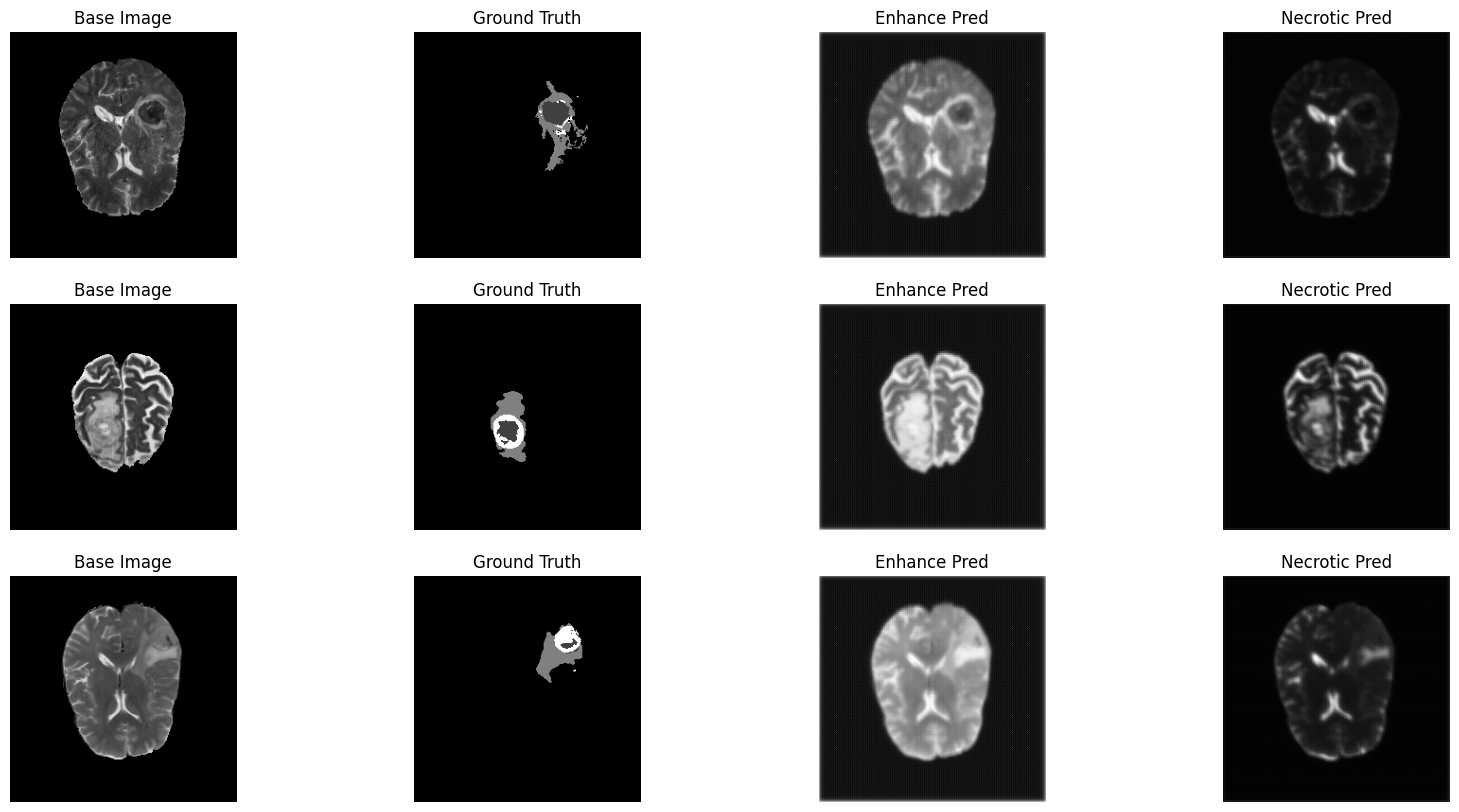

In [ ]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],4)

plt.figure(figsize=(20,10))

for i in range(0,3,1):

    plt.subplot(3,4,4*i+1)
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]), cmap = 'gray')
    plt.title("Base Image")
    plt.axis('off')
    
    plt.subplot(3,4,4*i+2)
    plt.imshow(np.squeeze(test_mask[pred_candidates[i]]), cmap = 'gray')
    plt.title("Ground Truth")
    plt.axis('off')
    
    plt.subplot(3,4,4*i+3)
    plt.imshow(np.squeeze(preds_enhance[pred_candidates[i]]), cmap = 'gray')
    plt.title("Enhance Pred")
    plt.axis('off')

    plt.subplot(3,4,4*i+4)
    plt.imshow(np.squeeze(preds_necrotic[pred_candidates[i]]), cmap = 'gray')
    plt.title("Necrotic Pred")
    plt.axis('off')

In [ ]:
enhance_true = create_enhance_masks(test_mask)
necrotic_true = create_necrotic_masks(test_mask)
enhance_pred = np.squeeze(preds_enhance)
necrotic_pred = np.squeeze(preds_necrotic) 

ntrs_true = []
ntrs_pred = []

for i in range(len(validation_vol)):

    enhance_area_pred = np.sum(enhance_pred[i])
    necrotic_area_pred = np.sum(necrotic_pred[i])
    enhance_area_true = np.sum(enhance_true[i]) / 256
    necrotic_area_true = np.sum(necrotic_true[i]) / 256

    ntr_true = necrotic_area_true / enhance_area_true
    ntr_pred = necrotic_area_pred / enhance_area_pred

    ntrs_true.append(ntr_true)
    ntrs_pred.append(ntr_pred)
    


In [ ]:
# Calculate MAE
mae = mean_absolute_error(ntrs_true, ntrs_pred)

# Calculate MSE
mse = mean_squared_error(ntrs_true, ntrs_pred)

# Calculate RMSE
rmse = np.sqrt(mse)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)


MAE: 0.793466726786077
MSE: 0.698929420702961
RMSE: 0.8360199882197561
